<a href="https://colab.research.google.com/github/flying-bear/kompluxternaya/blob/master/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3

1. Implement Logistic Regression with Stochastic Gradient Decent using numpy
1. Implement Logistic Regression with early stopping using pytorch

Additional readings:
1. https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html
1. https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

warnings.simplefilter("error")

# retrieve dataset
data = fetch_20newsgroups()


X_train = data['data']
y_train = data['target']

tfidf = TfidfVectorizer(max_df=0.5, min_df=10)
X_train = tfidf.fit_transform(X_train)

test_data = fetch_20newsgroups(subset='test')
X_test = tfidf.transform(test_data['data'])
y_test = test_data['target']

## 1 Binary Logistic Regression
$\{(x_i, y_i)\}_{i=1}^N$, $y \in \{0,1\}$
$$ z = Xw + b $$

$$p(y=1 | x) = \sigma(z) = \frac 1 {1 + e^{-z}}$$

$$ L_{batch} = - \frac 1 {|batch|} \sum_{i \in batch}^N [ y_i \log \sigma(z_i) + (1 - y_i) \log (1 - \sigma(z_i)) ] + \frac \lambda 2 w^T w$$

Stochastic Gradient Decent for logreg:
1. init w ~ random N(0,1), b = 0
1. for epoch = 1..n_epochs:
    * shuffle dataset
    * for every batch:
        * $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L_{batch}(w^{(t-1)},b^{(t-1)})$
        * $b^{(t)} \leftarrow b^{(t-1)} - \alpha \nabla_{b} L_{batch}(w^{(t-1)},b^{(t-1)})$
        
$w$ - weights  
$b$ - biases  
$\alpha$ - learning rate

Hint:
$$\nabla_w L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial w} + \frac {\partial (\frac \lambda 2 w^T w)} {\partial w} $$
$$\nabla_b L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial b} $$

In [2]:
# make dataset for binary classification

X_train_bin = X_train[y_train < 2]
y_train_bin = y_train[y_train < 2]

X_test_bin = X_test[y_test < 2]
y_test_bin = y_test[y_test < 2]

y_train_bin.shape, y_test_bin.shape

((1064,), (708,))

In [3]:
print(f'X shape: {X_train_bin.shape}')
print(f'y shape: {y_train_bin.shape}')
w_test_size = np.random.randn(X_train_bin.shape[1])
print(f'w shape: {w_test_size.shape}')
print(f'Xw shape: {(X_train_bin.dot(w_test_size)).shape}')

X shape: (1064, 15566)
y shape: (1064,)
w shape: (15566,)
Xw shape: (1064,)


In [0]:
# TRY TO IMPLEMENT LOSS on some 64 datapoints

llambda = 1
test_batch_X = X_train_bin[64:128, :]
test_batch_y = y_train_bin[64:128]
w = np.random.randn(test_batch_X.shape[1])
b = 0

In [0]:
def count_loss(batch_X, batch_y, w, b, llambda, batch_size):
  z = batch_X.dot(w) + b
  sigm = 1 / (1 + np.exp(-z))
  loss = (-1/batch_size) * (np.sum(batch_y*np.log(sigm) + (1-batch_y)*(np.log(1-sigm)))).item() + (llambda/2) * w.transpose().dot(w)
  return loss, sigm

In [6]:
test_loss, test_sigm = count_loss(test_batch_X, test_batch_y, w, b, llambda, test_batch_y.shape[0])
test_loss

7887.261590601861

**Gradient formulae**

$$\nabla_w L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial w} + \frac {\partial (\frac \lambda 2 w^T w)} {\partial w} $$
$$\nabla_b L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial b} $$

Посчитаем части формул
$$ L_{batch} = - \frac 1 {|batch|} \sum_{i \in batch}^N [ y_i \log \sigma(z_i) + (1 - y_i) \log (1 - \sigma(z_i)) ] + \frac \lambda 2 w^T w$$

$$\frac {\partial} {\partial \sigma}[y \log \sigma(z) + (1 - y) \log (1 - \sigma(z))] = \frac {y}{\sigma} + \frac {-1 \cdot (1 - y)}{1 - \sigma} = \frac {y(1 - \sigma) - \sigma(1 - y)} {\sigma(1 - \sigma)} = \frac {y - \sigma y - \sigma + \sigma y}{\sigma(1 - \sigma)} = \frac {y - \sigma}{\sigma(1 - \sigma)}$$

$$\frac {\partial L} {\partial \sigma} = -\frac {1} {|batch|} \frac {y - \sigma} {\sigma (1 - \sigma)}$$

$$\frac {\partial \sigma} {\partial z} = \frac 1 {1 + e^{-z}} \frac {e^{-z}} {(1 + e^{-z})^2} ={\sigma}({1 - \sigma})$$

$$ \frac {\partial z} {\partial w} = X^T $$

$$ \frac {\partial (\frac \lambda 2 w^T w)} {\partial w} = \lambda w$$

$$ \frac {\partial z} {\partial b} = 1 $$
Identity matrix


Соберём вместе

$$\nabla_w L = \frac {- \sigma (1 - \sigma) X^T} {|batch|} \frac {y - \sigma} {\sigma (1 - \sigma)} +  \lambda w = \frac {(\sigma - y) X^T} {|batch|}  +  \lambda w$$
$$\nabla_b L = \frac {\sigma - y} {|batch|}$$



In [12]:
# TRY TO IMPLEMENT GRADIENT
batch_size = test_batch_y.shape[0]
test_grad_w = (1/(batch_size)) * test_batch_X.transpose().dot((test_batch_y - test_sigm)) + llambda * w
test_grad_b = (1/(batch_size)) * test_batch_X.transpose().dot((test_batch_y - test_sigm)).dot(np.ones(test_grad_w.shape[0]))

test_grad_w.shape

(15566,)

In [13]:
# COMPARE LOSS BEFORE AND AFTER SGD
print(count_loss(test_batch_X, test_batch_y, w, b, llambda, test_batch_y.shape[0])[0])
print(count_loss(test_batch_X, test_batch_y, w-0.0001*test_grad_w, b-0.0001*test_grad_b, llambda, test_batch_y.shape[0])[0])

7887.261590601861
7885.684351759331


[gradient checking](https://datascience-enthusiast.com/DL/Improving_DeepNeural_Networks_Gradient_Checking.html)


In [0]:

class LogRegNumpy(ClassifierMixin):
    def __init__(self, llambda=1, lr=0.0001, batch_size=32, n_epochs=100):
        """
        llambda: regularization strength
        lr: learning rate
        """
        self.w = None
        self.b = 0
        self.llambda = llambda
        self.n_epochs = n_epochs
        self.lr = lr
        self.history = []
        self.batch_size = batch_size

    @staticmethod
    def sigmoid(z):
      return 1 / (1 + np.exp(-z))
    
    # def batch_loss(self, batch_X, batch_y, w, b, llambda, batch_size):
    #   """
    #   calculates loss over a batch with regularization
    #   :param batch_X: batch data, np.ndarray of shape (batch size, number of features)
    #   :param batch_y: batch labels, np.ndarray of shape (batch size,)
    #   :param w: weigths matrix, np.ndarray of shape (number of features,)
    #   :param b: bias, a number (int or float)
    #   :param llambda: regularizartion strength, a number (int or float)
    #   :param batch_size: batch size, int

    #   :return loss: loss, float
    #   :return sigm: predictions, np.ndarray of shape (batch size,)
    #   """
    #   z = batch_X.dot(w) + b
    #   # if np.isnan(np.sum(z)):
    #   #   return
    #   sigm = self.sigmoid(z)
    #   reg = (llambda/2) * w.transpose().dot(w)
    #   loss = (-1/batch_size) * np.sum(batch_y * np.log(sigm) + (1-batch_y) * (np.log(1-sigm))) + reg
    #   return loss, sigm

    def fit(self, X, y):
        self.w = np.random.randn(X.shape[1])
        self.b = 0
        
        for epoch in range(self.n_epochs):
            
            # random permutation over indices of dataset
            batch_indices = np.random.permutation(len(y))
            
            for j in range(0, len(y), self.batch_size):
                batch_idx = batch_indices[j:j+self.batch_size]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]
            
                # forward pass
                # <TODO> [1 point] calculate batch loss
                sigm = self.sigmoid(self.predict_proba(batch_X))
                loss =  np.sum((batch_y - 1) * np.log(1 - sigm) - batch_y * np.log(sigm))/self.batch_size + (self.llambda/2) * self.w.T.dot(self.w)

                # backward pass
                # <TODO> [2 points] calculate batch gradients 
                # dL_dsigm = (-1/self.batch_size) * np.sum((batch_y - sigm)/(sigm * (1-sigm)))
                # dsigm_dz = sigm * (1 - sigm)
                # grad_w = dL_dsigm * batch_X.transpose().dot(dsigm_dz) + self.llambda * self.w
                # grad_b = dL_dsigm * dsigm_dz.dot(np.ones(dsigm_dz.shape[0]))
                grad_w = (1/self.batch_size) *  batch_X.transpose().dot(sigm - batch_y) + self.llambda * self.w
                grad_b = (1/self.batch_size) * np.sum((sigm - batch_y))

                # # # check gradient of b
                # epsilon = 1e-7  # (is this epsilon small enough?)
                # margin = 1e-3
                # # b_minus_step_loss = self.batch_loss(batch_X, batch_y, self.w, self.b-epsilon, self.llambda, self.batch_size)[0]
                # # b_plus_step_loss = self.batch_loss(batch_X, batch_y, self.w, self.b+epsilon, self.llambda, self.batch_size)[0]
                # # approximate_grad_b = (b_plus_step_loss - b_minus_step_loss)/ (2*epsilon)
                # # print(grad_b, approximate_grad_b)
                # # b_difference = abs(grad_b-approximate_grad_b)/(abs(grad_b)+abs(approximate_grad_b))
                # # assert b_difference < margin, f"approximated gradient for b differs from calculated by {b_difference}"

                # # check gradient of w
                # param_num = self.w.shape[0]
                # w_plus_step_loss = np.zeros(param_num)
                # w_minus_step_loss = np.zeros(param_num)
                # approximate_grad_w = np.zeros(param_num)
                # for i in range(param_num):
                #   check_w_plus = np.copy(self.w)
                #   check_w_plus[i] += epsilon
                #   w_plus_step_loss[i] = self.batch_loss(batch_X, batch_y, check_w_plus, self.b, self.llambda, self.batch_size)[0]

                #   check_w_minus = np.copy(self.w)
                #   check_w_minus[i] -= epsilon
                #   w_minus_step_loss[i] = self.batch_loss(batch_X, batch_y, check_w_minus, self.b, self.llambda, self.batch_size)[0]

                #   approximate_grad_w[i] = (w_plus_step_loss[i] - w_minus_step_loss[i]) / (2 * epsilon)
                # w_difference = np.linalg.norm(grad_w - approximate_grad_w) / (np.linalg.norm(grad_w) + np.linalg.norm(approximate_grad_w))
                # assert w_difference < margin,  f"approximated gradient for w differs from calculated by {w_difference}"

                # SGD optimization step
                # <TODO> [1 point]
                self.w -= self.lr * grad_w
                self.b -= self.lr * grad_b
                
                self.history.append(loss)
        
        return self 
    
    def predict_proba(self, X):
        # <TODO> [1 point] calculate p(y=1 | x)
        z = X.dot(self.w) + self.b
        p = self.sigmoid(z)
        return p
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)

**I think that learning rate of 3 doesn't make sense, neither does llambda of 0.001. However, the reverse does. So I swapped them.**

test auc 0.5191996196339783


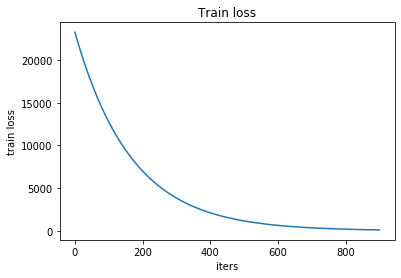

In [56]:
model = LogRegNumpy(llambda = 3, lr=0.001, batch_size=128, n_epochs=100)
model.fit(X_train_bin, y_train_bin)
print('test auc', metrics.roc_auc_score(y_test_bin, model.predict_proba(X_test_bin)))
plt.plot(np.arange(len(model.history)), model.history)
plt.xlabel('iters')
plt.ylabel('train loss')
plt.title('Train loss');

# Multinomial Logistic Regression using pytorch

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

###  [1 point] implement linear model $Z = XW + b$

In [0]:
class LogRegNN(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogRegNN, self).__init__()
        
        # create tensor of weights and tensor of biases
        # initialize tensors from N(0,1) 
        # W has shape (n_features, n_classes)
        # b has shape (n_classes,)
        self.W = nn.Parameter(torch.randn(n_features, n_classes))
        self.b = nn.Parameter(torch.randn(n_classes))
        
    def forward(self, x):
        """
        In this method we implement connections between neural network weights
        x: batch feature matrix
        returns: probability logits
        """
        # <TODO> implement linear model 
        result = x @ self.W + self.b
        return result

In [0]:
def train_batch(model, batch_x, batch_y):
    # set NN model in training mode
    model.train()
    
    # zero gradients
    optimizer.zero_grad()
    # forward pass
    pred = model(batch_x)
    # cross-entropy loss
    loss = criterion(pred, batch_y)
    # calculate gradients
    loss.backward()
    # make optimization step
    optimizer.step()
    
    # return batch loss
    return loss.data.detach().item()

def eval_batch(model, batch_x, batch_y):
    # set NN model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        # forward pass
        pred = model(batch_x)
        # cross-entropy loss
        loss = criterion(pred, batch_y)

    # return batch loss
    return loss.data.item()

### [2 points] implement early stopping using early_stopping_patience

In [0]:
from functools import reduce

In [0]:
def train(model, train_loader, valid_loader, n_epochs, early_stopping_patience=5):
    """
    early_stopping_patience - number of consecutive epochs of growing validation loss to wait
    """
    history = {'train': [], 'valid': []}

    # <TODO> implement early stopping using early_stopping_patience
    
    for epoch in range(n_epochs):
        epoch_train_loss = 0
        
        # iterate over batches
        for batch_x, batch_y in tqdm(train_loader, desc=f'epoch:{epoch}', leave=True):

            loss = train_batch(model, batch_x, batch_y)
            epoch_train_loss += loss

        # average loss for epoch
        epoch_train_loss /= len(train_loader)
        history['train'].append(epoch_train_loss)
        
        epoch_valid_loss = 0
        for batch_x, batch_y in valid_loader:
            loss = eval_batch(model, batch_x, batch_y)
            epoch_valid_loss += loss
            
        epoch_valid_loss /= len(valid_loader)
        print(f'train loss: {epoch_train_loss:.3f} valid loss:{epoch_valid_loss:.3f}')
        history['valid'].append(epoch_valid_loss)
        
        # <TODO> implement early stopping using early_stopping_patience
        if len(history['valid']) > early_stopping_patience:
          if reduce(lambda x, y: x < y, history['valid'][-early_stopping_patience:]):
            print('Early Stopping!')
            break

    return history 

### predict hard labels [1 point]

In [0]:
def predict(model, test_loader):
    
    model.eval()
    
    result = []
    with torch.no_grad():
        for batch_x in test_loader:
          # <TODO> predict hard labels
          logit = model.forward(batch_x)
          all_classes = torch.nn.functional.softmax(logit, dim = 1)
          pred = np.argmax(all_classes, axis=1)
          result.append(pred)
    return np.concatenate(result)

DataLoader implements iteration over batches and shuffling

L2 regularization coef is embedded into SGD.weight_decay: 

1. $w^{(t-1)} \leftarrow w^{(t-2)} - \alpha \lambda w^{(t-2)} $  
1. $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L(w^{(t-1)}) $

here   
$\alpha$ - learning rate  
$\lambda$ - weight-decay = L2 regularization coef

In [123]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train, y_train, stratify=y_train,
                                                      shuffle=True, test_size=0.2, random_state=42)

batch_size = 256


train_loader = DataLoader(TensorDataset(torch.tensor(X_train2.todense()).float(), torch.tensor(y_train2).long()), 
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_valid2.todense()).float(), torch.tensor(y_valid2).long()), 
                          batch_size=batch_size)
test_loader = DataLoader(torch.tensor(X_test.todense()).float(), 
                          batch_size=batch_size)

model = LogRegNN(X_train.shape[1], 20)

criterion = nn.CrossEntropyLoss()
# L2 regularization is embeded in 
optimizer = optim.SGD(model.parameters(), lr=10.0, weight_decay=0.0001)

history = train(model, train_loader, valid_loader, 100, 2)

train loss: 3.258 valid loss:3.055


train loss: 2.819 valid loss:2.718


train loss: 2.469 valid loss:2.420


train loss: 2.182 valid loss:2.200


train loss: 1.951 valid loss:1.994


train loss: 1.760 valid loss:1.848


train loss: 1.611 valid loss:1.733


train loss: 1.490 valid loss:1.623


train loss: 1.384 valid loss:1.539


train loss: 1.298 valid loss:1.465


train loss: 1.226 valid loss:1.401


train loss: 1.165 valid loss:1.352


train loss: 1.110 valid loss:1.307


train loss: 1.066 valid loss:1.270


train loss: 1.025 valid loss:1.236


train loss: 0.991 valid loss:1.208


train loss: 0.959 valid loss:1.181


train loss: 0.933 valid loss:1.161


train loss: 0.909 valid loss:1.128


train loss: 0.885 valid loss:1.113


train loss: 0.869 valid loss:1.101


train loss: 0.849 valid loss:1.088


train loss: 0.835 valid loss:1.074


train loss: 0.819 valid loss:1.060


train loss: 0.809 valid loss:1.056


train loss: 0.800 valid loss:1.045


train loss: 0.789 valid loss:1.040


train loss: 0.780 valid loss:1.027


train loss: 0.772 valid loss:1.018


train loss: 0.763 valid loss:1.011


train loss: 0.757 valid loss:1.007


train loss: 0.751 valid loss:1.006


train loss: 0.743 valid loss:0.995


train loss: 0.740 valid loss:0.998
Early Stopping!


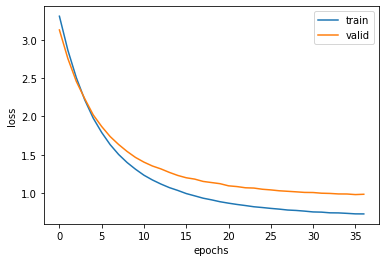

In [103]:
plt.plot(np.arange(len(history['train'])), history['train'], label='train')
plt.plot(np.arange(len(history['valid'])), history['valid'], label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [104]:
y_pred = predict(model, test_loader)
metrics.accuracy_score(y_test, y_pred)

[12 12  0 ... 13 12 15]


0.7845193839617631

### What is the cross-entropy loss of uniformly random guessing classifier for this task? [0.5 point]

$$CELoss = - \sum_{i = 1}^{|labels|}(y_i log(softmax(x)))$$

когда x - случайно выбран, он выглядит как дискретное распределение вероятностей [0, 0, 1, ..., 0], и с вероятностью $\frac{1}{|labels|} = 0.05$ он угадает

In [134]:
y_pred_random = np.round(np.random.uniform(0, 1, (len(y_test), 20)))
torch.nn.functional.cross_entropy(torch.tensor(y_pred_random), torch.tensor(y_test)).item()

3.109251554607069

### What is the accuracy of constant prediction classifier for this task? [0.5 point]

$$conatsnt\ accuracy\ score = \frac{1}{number\ of\ labels} = \frac{1}{20} = 0.05$$

In [129]:
y_pred_constant = [17]*len(y_test)
print(metrics.accuracy_score(y_test, y_pred_constant))

sc = []
for i in range(20):
  y_pred_constant = [i]*len(y_test)
  sc.append(metrics.accuracy_score(y_test, y_pred_constant))

print(np.mean(sc))

0.04992033988316516
0.05000000000000001
